In [1]:
import numpy as np
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
import matplotlib.pyplot as pp
from scipy.signal import find_peaks
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3
import matplotlib as mpl
import math
from operator import add
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import pims
import trackpy as tp
from skimage.feature import peak_local_max
from scipy.ndimage.morphology import distance_transform_edt as edt
from IPython.display import clear_output
import timeit

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(20, 20))
mpl.rc('image', cmap='gray')
# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

def collect(x, y, sigma):
    neighborhood = []
    X = int(sigma)
    for i in range(-X, X + 1):
        Y = int(pow(sigma * sigma - i * i, 1/2))
        for j in range(-Y, Y + 1):
            neighborhood.append((x + i, y + j))
    return neighborhood

#Image Loading
str1 = 'images/'
date = '05_04_19'
name = '30uL_In_dots_spundown_retest_dish2_kgluc_added_frame_80_150ms'
other = '/jpgs/'# non_normalised for dots, dyeChannel for dyes
extension = '*.jpg'
path = str1+date+'/'+name+other+extension

frames = pims.ImageSequence(path, as_grey=True)

In [14]:
total_frames = len(frames)

image1= np.int64(frames[0])
for frameNum in range(1, total_frames-1):
    image1 = image1-np.int64(frames[frameNum])

image1[image1 > np.amin(image1)*0.5] = 0

#image1= np.float64(frames[0])
#for frameNum in range(1, total_frames-1):
#    image1 = np.sum([image1,np.int64(frames[frameNum])],axis=0)
#image1[image1 > np.amin(image1)*0.5] = 0    

#image1 = image1*-1
#image1 = image1/image1.max()
#image1 = np.array(image1 * 255, dtype = np.uint8)
#image1 = np.stack((image1,)*3, axis=-1)

im = edt(image1)
roi_size = 15

#im = edt(np.abs(image1-1))

coordinates = peak_local_max(im, min_distance=roi_size*3,threshold_rel = 0.15)

print(len(coordinates))

good_coordinates = coordinates#[np.array([0,10,11,12,13,14,15,17,20,24,28,36,37,38])]

total_particles = len(good_coordinates)
particle_index = np.linspace(0,total_particles-1,total_particles,dtype='int')
particle_coords = [0] * total_frames
particle_roi_dict = dict(zip(particle_index, particle_coords))

for index, shift in enumerate(good_coordinates):
    current_coords = [0,0]
    centre_x = shift[1]
    centre_y = shift[0] 
    particle_roi_dict[index] = collect(int(centre_x), int(centre_y), roi_size)

184


184


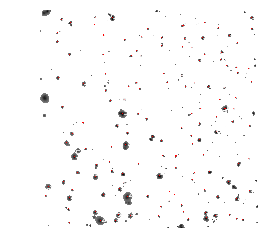

In [6]:
pp.figure()
pp.imshow(image1, cmap=pp.cm.gray)
pp.autoscale(False)
pp.axis('off')

print(len(good_coordinates))

pp.plot(good_coordinates[:,1],good_coordinates[:,0],'r,')

z=0
for xy in zip(good_coordinates[:,1], good_coordinates[:,0]):                                      
    pp.annotate(str(z), xy=xy,color='white',xytext=xy) 
    z = z+1

In [11]:
noParticles = len(particle_roi_dict)

frame_index = np.linspace(0,total_frames-1,total_frames,dtype='int')
frame_intensity = [0] * total_frames
overall_dict = dict(zip(frame_index, frame_intensity))

#subsection = frames[:5]

start = timeit.default_timer()

#for key0, value0 in enumerate(particle_roi_dict):  #Key0: particle number
#    clear_output(wait=True)    
#    current_particle_intensity = 0
#    particle_dict = dict()
#    for key1, value1 in enumerate(frames): #key1: frame number, value1: frame info
#        #current_particle_intensity = 0
#        #for key2, value2 in enumerate(particle_roi_dict[key0]):  #key2: particle coord index, value2: particle roi coord
#        #    current_particle_intensity = current_particle_intensity + value1[value2[0]][value2[1]] #intensity for one ROI in one frame
#        #particle_dict[key1] = current_particle_intensity
#        a = np.asarray(particle_roi_dict[key0])
#        particle_dict[key1] = np.sum(value1[a[:,0],a[:,1]])
#    overall_dict[key0] = particle_dict
    
for key1, value1 in enumerate(frames): #key1: frame number, value1: frame info
    clear_output(wait=True)
    current_particle_intensity = 0
    particle_dict = dict()
    for key0, value0 in enumerate(particle_roi_dict): #Key0: particle number
        a = np.asarray(particle_roi_dict[key0])
        particle_dict[key0] = np.sum(value1[a[:,0],a[:,1]])
    overall_dict[key1] = particle_dict
        
    stop = timeit.default_timer()
    if (key1/len(frames)*100) <5 :
        expected_time = "Calculating..."
    else:
        time_perc = timeit.default_timer()
        expected_time = np.round(((time_perc-start)/(key1/len(frames)))/60,2)
    print("Current progress:",np.round(key1/len(frames)*100,2),"%")
    print("Current run time:",np.round((stop-start)/60,2),"minutes")
    print("Expected run time:",expected_time,"minutes")
    
new_overall_dict = dict()
for key0 in range(0,len(overall_dict[0])): #key1: particle number
    new_current_particle = dict()
    for key1 in range(0,len(overall_dict)): #key1: frame number
        new_current_particle[key1]=overall_dict[key1][key0]
    new_overall_dict[key0] = new_current_particle
    

Current progress: 99.71 %
Current run time: 0.22 minutes
Expected run time: 0.22 minutes


In [204]:
for particle in range(0, noParticles): 
    fig = pp.figure()
    ax = pp.axes()
    ax.plot(new_overall_dict[particle].keys(), new_overall_dict[particle].values());
    fig.savefig(str(particle)+'.png', bbox_inches='tight')
    pp.close('all')

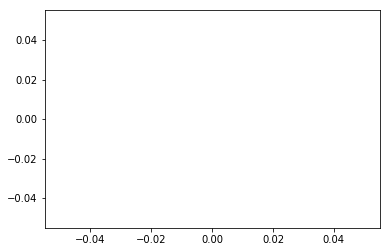

In [12]:
particle = 181
pp.plot(overall_dict[particle].keys(), overall_dict[particle].values());

In [25]:
a = np.asarray(particle_roi_dict[key0])
print(a)

[[1626  102]
 [1627   97]
 [1627   98]
 ...
 [1655  106]
 [1655  107]
 [1656  102]]
